<a href="https://colab.research.google.com/github/CUSPADS2022IBX/IBXRidership/blob/main/Models/Spatial_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pysal
!pip install geopandas

In [2]:
import networkx as nx #library supporting networks
import matplotlib.pyplot as plt #plotting
import geopandas as gpd
from pysal.lib import weights
from spreg import GM_Lag
import spreg.diagnostics as D
import pandas as pd
import numpy as np
import scipy.stats as stat

/usr/local/lib/python3.7/dist-packages/geopandas/_compat.py:115: UserWarning: The Shapely GEOS version (3.10.2-CAPI-1.16.0) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string


In [4]:
# subway_ibx_peak = nx.read_gml('IBX_peak.gml')
# subway_ibx_offpeak = nx.read_gml('IBX_offpeak.gml')
subway_base_peak = nx.read_gml('base_peak.gml')
subway_base_offpeak = nx.read_gml('base_offpeak.gml')

In [5]:
main_nodes_ibx = pd.read_csv('ctrl_scrs_sta_IBX_peak.csv', index_col = 0)

In [6]:
main_nodes_base = pd.read_csv('ctrl_scrs_sta_noIBX_peak.csv', index_col = 0)

In [7]:
main_nodes_mapped = pd.read_csv('complex_centralities.csv', index_col = 0); main_nodes_mapped

,complex_id,Stop Name,Complex_id,cs_ibx_peak,cs_ibx_offpeak,cs_noibx_peak,cs_noibx_offpeak
0,614,59 ST-COLUMBUS CIRCLE,614c,0.022481,0.013806,0.022649,0.013907
1,611,42 ST-PORT AUTHORITY BUS TERMINAL,611c,0.025420,0.016341,0.025604,0.016466
2,601,14 ST,601c,0.024272,0.014947,0.024396,0.015019
3,635,SOUTH FERRY,635c,0.020350,0.012717,0.020454,0.012778
4,620,BOROUGH HALL,620c,0.021319,0.013528,0.021334,0.013548
...,...,...,...,...,...,...,...
428,X14,NaN,X14,0.016863,0.009802,NaN,NaN
429,X15,NaN,X15,0.016903,0.009810,NaN,NaN
430,X6,NaN,X6,0.016624,0.010000,NaN,NaN
431,X7,NaN,X7,0.016464,0.009949,NaN,NaN


In [8]:
complex_gtfs_dict = pd.Series(main_nodes_mapped['complex_id'].values, index = main_nodes_mapped['Complex_id'].values).to_dict()

In [41]:
data_base_log = pd.read_csv('mg_noIBX_log.csv', index_col = 0)
data_base_log['complex_id'] = data_base_log['complex_id'].map(lambda x: str(x))
data_base_log = data_base_log.sort_values(by = 'complex_id', ignore_index = True); data_base_log

,complex_id,Stop Name,Complex_id,exits_weekday_evening,entries_weekday_evening,exits_weekday_morning,entries_weekday_morning,exits_weekday_overnight,entries_weekday_overnight,exits_weekend_evening,entries_weekend_evening,exits_weekend_morning,entries_weekend_morning,exits_weekend_overnight,entries_weekend_overnight,cs_ibx_peak,cs_ibx_offpeak,cs_noibx_peak,cs_noibx_offpeak,VoroID,lotarea,bldgarea,comarea,resarea,officearea,retailarea,garagearea,strgearea,factryarea,otherarea,numbldgs,numfloors,unitsres,unitstotal,assesstot,Total_pop_Num,housed_pop_Num,group_house_pop_num,industrial_pop_num,under18_num,hispanic_num,white_num,black_num,asian_num,other_num,multirace_num,total_houses,occupied_homes_num,vacant_homes_num,Bus_Stops,geometry,Complex ID,boro,lat,long
0,1,ASTORIA-DITMARS BLVD,R01,8.652707,7.403792,8.148287,8.528484,6.132693,5.475522,8.017204,7.106760,7.674095,7.661939,6.426691,4.908049,0.016242,0.010671,0.016281,0.010718,70.0,17.630596,16.975899,15.701532,16.575058,13.724625,13.909945,13.363050,13.978097,14.116205,14.160365,9.062799,9.519403,9.850441,9.943320,21.132556,10.686734,10.680074,5.671646,-inf,8.783198,9.086447,10.213574,6.943512,8.410315,6.302721,7.371530,9.911190,9.850095,7.085475,4.204693,MULTIPOLYGON (((1009459.8773626394 218152.2372...,1,Q,40.775036,-73.912034
1,10,49 ST,R15,8.461638,8.514505,8.931188,8.060501,6.083417,5.744684,8.486966,8.321832,8.538979,7.855738,6.474373,6.325367,0.022245,0.013315,0.022382,0.013371,307.0,13.669265,16.425204,16.071395,13.755709,15.830454,14.032714,12.162063,12.058400,-inf,12.987466,4.250825,6.850687,7.084588,7.625215,21.607284,7.491832,7.308456,5.705329,3.784344,4.876557,5.710162,6.369599,5.702556,6.287261,3.188194,3.829414,7.149632,6.887089,5.683890,0.693147,POLYGON ((989185.1866888272 216357.86476792034...,10,M,40.759901,-73.984139
2,100,HEWES ST,M14,6.842657,6.363287,6.721727,6.334966,5.211806,4.220977,6.578296,5.851664,6.042039,5.622211,5.622437,4.327438,0.020128,0.012387,0.020046,0.012377,179.0,14.534087,15.337841,14.101496,14.923624,12.378465,12.281295,11.002797,9.177329,11.358155,13.490262,6.537753,7.653371,8.110755,8.202652,19.212147,9.207392,9.198816,4.444276,1.685130,8.131600,7.798253,8.817585,4.953395,5.392477,5.272092,5.420767,8.110404,8.030336,5.545750,1.945910,"POLYGON ((996888.2585780247 198332.7126279529,...",100,Bk,40.706870,-73.953431
3,101,MARCY AV,M16,8.269411,7.801606,8.124284,7.646867,6.278850,5.635057,7.918560,7.270791,7.534562,6.898084,6.626801,5.833531,0.020578,0.012626,0.020522,0.012624,180.0,16.434464,17.075895,15.912474,16.670518,14.251774,14.101396,12.921272,12.471208,13.307646,15.198090,7.709226,8.821562,9.781926,9.861856,21.144624,10.792410,10.786134,5.718285,4.946630,9.666835,9.222319,10.396247,7.622212,7.311999,6.875067,7.157745,9.800038,9.719475,7.241308,4.060443,POLYGON ((995891.3762889279 194519.11313010252...,101,Bk,40.708359,-73.957757
4,103,BOWERY,M19,6.841776,6.487874,7.250511,6.326105,4.791442,3.824284,7.013747,6.454904,7.322717,6.080791,5.368601,4.912655,0.020696,0.011852,0.020766,0.011917,279.0,13.767938,15.216583,14.393646,14.522429,13.420507,13.348530,10.955179,10.905860,8.832096,12.803664,5.488691,7.056912,7.920266,8.145508,20.151044,8.550787,8.475888,5.921961,-inf,6.155664,6.606777,7.563697,5.451459,7.626830,4.006081,5.095052,7.912346,7.806271,5.616165,1.098612,POLYGON ((986852.7345749646 201652.06074943082...,103,M,40.720280,-73.993915
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
419,95,GATES AV,J30,7.134074,6.931692,6.462132,7.479215,5.629508,4.824707,6.613049,6.547592,5.826553,6.671083,5.768712,4.747104,0.017714,0.010729,0.017565,0.010743,151.0,15.443623,15.941735,14.112842,15.664420,11.646843,12.767356,10.515421,10.592798,9.977850,13.570278,7.569214,8.495740,8.893599,8.932900,19.727933,9.772230,9.741209,6.283680,-inf,7.896938,8.545320,8.188728,8.83

##### Method Test

In [94]:
base_peak_tt = dict(nx.shortest_path_length(subway_base_peak, weight = 'travel_time'))

base_peak_tt = pd.DataFrame.from_dict(base_peak_tt)

#ibx_peak_tt = ibx_peak_tt.rename(complex_gtfs_dict, axis = 'columns')

#ibx_peak_tt = ibx_peak_tt.rename(complex_gtfs_dict, axis = 'index')


In [95]:
base_peak_tt

,614c,125,A24,611c,127,725,R16,A27,601c,132,...,R40-R-N,R41-N-N,R41-R-N,R42-R-N,R43-R-N,R44-R-N,R45-R-N,S01-S-N,S03-S-N,S04-S-N
614c,0.000000,3.000000,3.000000,18.859089,16.516173,21.859089,21.859089,15.859089,24.642526,21.642526,...,52.235989,54.474644,53.618347,55.725365,57.277908,59.374738,61.177036,49.974265,48.597501,47.539419
125,3.000000,0.000000,6.000000,16.516173,13.516173,19.516173,19.516173,18.859089,21.642526,18.642526,...,55.235989,57.474644,56.618347,58.725365,60.277908,62.374738,64.177036,52.974265,51.597501,50.539419
A24,3.000000,6.000000,0.000000,15.859089,18.859089,18.859089,18.859089,12.859089,27.642526,24.642526,...,49.235989,51.474644,50.618347,52.725365,54.277908,56.374738,58.177036,46.974265,45.597501,44.539419
125-1-S,8.000000,5.000000,11.000000,11.516176,8.516176,14.516176,14.516176,14.516176,16.642539,13.642539,...,57.440603,53.394019,58.822960,60.929979,62.482522,64.579351,66.381650,57.974265,56.597501,55.539419
125-1-N,8.000000,5.000000,11.000000,11.516173,8.516173,14.516173,14.516173,14.516173,16.642526,13.642526,...,57.440582,53.394016,58.822940,60.929958,62.482501,64.579330,66.381629,57.974265,56.597501,55.539419
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
H14-S-N,91.031522,94.031522,88.031522,88.058715,91.058715,91.058715,91.058715,85.058715,93.404041,96.404041,...,94.664902,105.140951,96.047260,98.154279,99.706821,101.803651,103.605950,82.137360,83.514124,84.572207
H14-S-S,91.031541,94.031541,88.031541,88.058735,91.058735,91.058735,91.058735,85.058735,93.404061,96.404061,...,94.664922,105.140970,96.047280,98.154298,99.706841,101.803671,103.605969,82.137380,83.514144,84.572226
H11,92.432799,95.432799,89.432799,89.459992,92.459992,92.459992,92.459992,86.459992,94.805318,97.805318,...,96.066179,106.542227,97.448537,99.555555,101.108098,103.204928,105.007226,83.538637,84.915401,85.973483
H15-S-N,92.537535,95.537535,89.537535,89.564728,92.564728,92.564728,92.564728,86.564728,94.910054,97.910054,...,96.170915,106.646963,97.553273,99.660291,101.212834,103.309664,105.111962,83.643373,85.020137,86.078219


In [96]:
base_peak_tt = base_peak_tt.filter(items = main_nodes_base.index, axis = 'columns')

base_peak_tt = base_peak_tt.filter(items = main_nodes_base.index, axis = 'index')

base_peak_tt

,614c,611c,601c,635c,620c,617c,626c,604c,603c,628c,...,R35,R36,R39,R40,R41,R42,R43,R44,R45,S03
614c,0.000000,18.859089,24.642526,34.469947,47.618892,36.718608,45.539419,34.430320,45.463362,30.947104,...,51.674674,44.896463,55.834753,57.235989,58.618347,60.725365,62.277908,64.374738,66.177036,53.597501
611c,18.859089,0.000000,21.126353,30.953774,35.735570,34.696062,43.912373,47.289409,39.693653,27.974297,...,46.283305,42.299661,50.443384,51.844620,46.877843,55.333996,56.886539,58.983368,60.785667,51.970455
601c,24.642526,21.126353,0.000000,25.827422,30.325177,33.909738,39.335832,51.815691,45.216334,23.968999,...,51.832078,46.548848,56.000838,57.402074,58.784432,60.891450,62.443993,64.540823,66.343121,53.393914
635c,34.469947,30.953774,25.827422,0.000000,21.243462,25.880249,44.274064,68.442546,63.840116,31.437791,...,30.409320,32.578523,34.569399,35.970634,37.352992,39.460011,41.012554,43.109383,44.911682,52.332146
620c,47.618892,35.735570,30.325177,21.243462,0.000000,19.584561,24.430728,57.567122,55.107188,22.356178,...,25.165858,27.335061,29.325937,30.727172,32.109530,34.216549,35.769091,37.865921,39.668220,38.488810
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
R42,60.725365,55.333996,60.891450,39.460011,34.216549,29.579762,51.056754,79.155685,89.323737,54.617540,...,19.059372,16.881488,14.917450,13.516214,12.107019,0.000000,11.552543,13.649372,15.451671,60.195157
R43,62.277908,56.886539,62.443993,41.012554,35.769091,31.132305,52.609296,80.708228,90.876279,56.170083,...,20.611915,18.434031,16.469992,15.068757,13.659561,11.552543,0.000000,12.096829,13.899128,61.747700
R44,64.374738,58.983368,64.540823,43.109383,37.865921,33.229134,54.706126,82.805057,92.973109,58.266912,...,22.708744,20.530860,18.566822,17.165586,15.756391,13.649372,12.096829,0.000000,11.802299,63.844530
R45,66.177036,60.785667,66.343121,44.911682,39.668220,35.031433,56.508425,84.607356,94.775408,60.069211,...,24.511043,22.333159,20.369121,18.967885,17.558690,15.451671,13.899128,11.802299,0.000000,65.646828


In [97]:
base_peak_tt = base_peak_tt.rename(complex_gtfs_dict, axis = 'index')
base_peak_tt = base_peak_tt.rename(complex_gtfs_dict, axis = 'columns')
base_peak_tt

,614,611,601,635,620,617,626,604,603,628,...,31,32,33,34,35,36,37,38,39,141
614,0.000000,18.859089,24.642526,34.469947,47.618892,36.718608,45.539419,34.430320,45.463362,30.947104,...,51.674674,44.896463,55.834753,57.235989,58.618347,60.725365,62.277908,64.374738,66.177036,53.597501
611,18.859089,0.000000,21.126353,30.953774,35.735570,34.696062,43.912373,47.289409,39.693653,27.974297,...,46.283305,42.299661,50.443384,51.844620,46.877843,55.333996,56.886539,58.983368,60.785667,51.970455
601,24.642526,21.126353,0.000000,25.827422,30.325177,33.909738,39.335832,51.815691,45.216334,23.968999,...,51.832078,46.548848,56.000838,57.402074,58.784432,60.891450,62.443993,64.540823,66.343121,53.393914
635,34.469947,30.953774,25.827422,0.000000,21.243462,25.880249,44.274064,68.442546,63.840116,31.437791,...,30.409320,32.578523,34.569399,35.970634,37.352992,39.460011,41.012554,43.109383,44.911682,52.332146
620,47.618892,35.735570,30.325177,21.243462,0.000000,19.584561,24.430728,57.567122,55.107188,22.356178,...,25.165858,27.335061,29.325937,30.727172,32.109530,34.216549,35.769091,37.865921,39.668220,38.488810
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36,60.725365,55.333996,60.891450,39.460011,34.216549,29.579762,51.056754,79.155685,89.323737,54.617540,...,19.059372,16.881488,14.917450,13.516214,12.107019,0.000000,11.552543,13.649372,15.451671,60.195157
37,62.277908,56.886539,62.443993,41.012554,35.769091,31.132305,52.609296,80.708228,90.876279,56.170083,...,20.611915,18.434031,16.469992,15.068757,13.659561,11.552543,0.000000,12.096829,13.899128,61.747700
38,64.374738,58.983368,64.540823,43.109383,37.865921,33.229134,54.706126,82.805057,92.973109,58.266912,...,22.708744,20.530860,18.566822,17.165586,15.756391,13.649372,12.096829,0.000000,11.802299,63.844530
39,66.177036,60.785667,66.343121,44.911682,39.668220,35.031433,56.508425,84.607356,94.775408,60.069211,...,24.511043,22.333159,20.369121,18.967885,17.558690,15.451671,13.899128,11.802299,0.000000,65.646828


In [98]:
base_peak_weights = base_peak_tt.to_dict(orient='list')
base_peak_weights.keys()

dict_keys(['614', '611', '601', '635', '620', '617', '626', '604', '603', '628', '613', '610', '602', '619', '623', '622', '616', '606', '605', '167', '624', '636', '627', '621', '151', '609', '607', '612', '625', '608', '629', '618', '630', '615', '461', '223', '42', '135', '349', '293', '294', '295', '296', '297', '298', '299', '300', '301', '303', '304', '305', '306', '307', '308', '309', '310', '311', '312', '313', '314', '316', '318', '319', '320', '321', '323', '324', '325', '326', '327', '328', '329', '416', '417', '418', '419', '420', '421', '422', '423', '424', '425', '426', '427', '428', '429', '430', '431', '432', '433', '434', '438', '439', '440', '441', '333', '334', '336', '337', '339', '340', '341', '353', '354', '355', '356', '357', '358', '359', '343', '344', '345', '346', '347', '348', '350', '351', '352', '436', '437', '378', '379', '380', '381', '382', '383', '384', '385', '386', '387', '388', '391', '413', '414', '442', '443', '444', '445', '446', '360', '361', '36

In [99]:
neighbors_base = {}

for x in base_peak_tt.index.to_list():

  neighbors_base[x] = base_peak_tt.columns.to_list()

In [100]:
w = weights.W(neighbors=neighbors_base, weights=base_peak_weights)

In [101]:
w.set_transform(value = 'r')

In [196]:
print(w.full()[1][:50])
print(data_base_norm['complex_id'].values[:50])

['1', '10', '100', '101', '103', '107', '108', '109', '110', '111', '113', '114', '118', '119', '120', '122', '123', '124', '125', '126', '127', '129', '13', '130', '131', '133', '134', '135', '136', '137', '138', '14', '141', '143', '144', '145', '146', '147', '149', '150', '151', '152', '153', '154', '155', '156', '157', '158', '159', '16']
['1' '10' '100' '101' '103' '107' '108' '109' '110' '111' '113' '114'
 '118' '119' '120' '122' '123' '124' '125' '126' '127' '129' '13' '130'
 '131' '133' '134' '135' '136' '137' '138' '14' '141' '143' '144' '145'
 '146' '147' '149' '150' '151' '152' '153' '154' '155' '156' '157' '158'
 '159' '16']


In [202]:
#w.full()[1][:50]
data_base_norm['complex_id'].values

array(['1', '10', '100', '101', '103', '107', '108', '109', '110', '111',
       '113', '114', '118', '119', '120', '122', '123', '124', '125',
       '126', '127', '129', '13', '130', '131', '133', '134', '135',
       '136', '137', '138', '14', '141', '143', '144', '145', '146',
       '147', '149', '150', '151', '152', '153', '154', '155', '156',
       '157', '158', '159', '16', '160', '162', '164', '165', '167',
       '168', '169', '17', '173', '175', '176', '177', '179', '180',
       '181', '182', '183', '185', '186', '187', '188', '189', '190',
       '191', '192', '193', '194', '195', '196', '197', '198', '199', '2',
       '20', '200', '201', '202', '203', '204', '205', '206', '207',
       '208', '209', '210', '211', '212', '213', '214', '215', '216',
       '217', '218', '22', '220', '221', '222', '223', '224', '225',
       '228', '231', '232', '234', '235', '236', '237', '238', '240',
       '241', '242', '243', '244', '245', '246', '247', '248', '249',
       '250', '25

In [199]:
pd.set_option('max_columns', None)

#### Generating Spatial Weight Matrices

In [69]:
def generate_W(G, isIbx):

  tt = dict(nx.shortest_path_length(G, weight = 'travel_time'))

  tt = pd.DataFrame.from_dict(tt)

  if isIbx == True:


    tt = tt.filter(items = main_nodes_ibx.index, axis = 'columns')
    tt = tt.filter(items = main_nodes_ibx.index, axis = 'index')

  else:

    tt = tt.filter(items = main_nodes_base.index, axis = 'columns')
    tt = tt.filter(items = main_nodes_base.index, axis = 'index')

  tt = tt.rename(complex_gtfs_dict, axis = 'index')
  tt = tt.rename(complex_gtfs_dict, axis = 'columns')

  wts = tt.to_dict(orient = 'list')

  neighbors = {}

  for x in tt.index.to_list():

    neighbors[x] = tt.columns.to_list()

  w = weights.W(neighbors=neighbors, weights=wts)

  #w.transform = 'r'

  return w

In [70]:
W_base_peak = generate_W(subway_base_peak, False)
#W_ibx_peak = generate_W(subway_ibx_peak, True)

In [13]:
#W_ibx_offpeak = generate_W(subway_ibx_offpeak, True)
W_base_offpeak = generate_W(subway_base_offpeak, False)

In [71]:
W_base_peakdf = pd.DataFrame(W_base_peak.full()[0]); W_base_peakdf
# W_base_offpeakdf = pd.DataFrame(W_base_offpeak.full()[0])
# W_ibx_peakdf = pd.DataFrame(W_ibx_peak.full()[0])
# W_ibx_offpeakdf = pd.DataFrame(W_ibx_offpeak.full()[0])

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,300,301,302,303,304,305,306,307,308,309,310,311,312,313,314,315,316,317,318,319,320,321,322,323,324,325,326,327,328,329,330,331,332,333,334,335,336,337,338,339,340,341,342,343,344,345,346,347,348,349,350,351,352,353,354,355,356,357,358,359,360,361,362,363,364,365,366,367,368,369,370,371,372,373,374,375,376,377,378,379,380,381,382,383,384,385,386,387,388,389,390,391,392,393,394,395,396,397,398,399,400,401,402,403,404,405,406,407,408,409,410,411,412,413,414,415,416,417,418,419,420,421,422,423
0,0.000000,29.291887,65.945998,64.973588,57.987773,60.280752,80.926677,79.024507,77.475404,76.420897,73.598781,72.009519,52.812057,53.805774,59.718469,62.447533,63.384664,64.460769,65.818727,67.801818,68.923840,72.395636,33.434027,74.133891,75.660438,77.635565,79.170622,80.552255,81.925478,84.000339,85.096746,34.543828,79.522694,76.513223,75.054396,73.082981,71.219683,70.154210,68.055041,66.692124,67.710684,63.337127,61.159242,59.977435,58.736354,57.487868,56.256823,54.658283,53.431708,37.466123,51.815161,48.262633,48.114045,49.697035,52.310898,54.710175,56.089353,39.341895,62.750139,65.508694,67.902460,69.547751,72.023345,74.242510,75.581867,77.949922,79.582832,82.609029,83.832743,85.636165,86.193440,87.524829,88.747604,90.107683,91.487264,92.639756,93.811921,95.021221,94.870843,94.870843,96.828081,109.428490,11.710931,42.789128,114.262509,115.667724,117.025211,118.574239,114.797142,116.351398,118.612490,120.141451,121.795488,123.215495,89.308787,83.416919,81.604634,80.109432,78.809564,77.292569,75.952902,74.339999,72.799183,44.869938,68.718820,43.095303,40.803635,28.054320,40.175194,41.928392,46.103774,56.111540,52.396825,54.881702,57.970533,61.880028,63.512623,65.170757,68.605617,70.062476,72.513930,74.321317,76.285113,77.862460,78.961399,80.089983,81.485286,83.021150,84.431586,86.196536,87.785998,89.898914,76.327692,74.424242,72.474248,71.002565,69.110973,66.774164,57.481113,65.263840,63.687701,62.890989,60.753926,58.866025,56.814948,54.956985,52.363167,50.495348,48.639338,47.033141,44.820441,42.605599,50.247140,49.026403,80.798717,79.487419,62.798358,77.793272,53.286001,56.429773,58.128173,62.553419,63.913429,65.312385,66.740551,67.940088,69.180287,70.743590,85.823115,84.564877,82.884163,81.412435,79.722592,78.304217,76.625666,12.879433,66.779988,75.067266,73.386712,68.844828,66.644901,65.310695,63.422694,61.114381,60.011890,58.812819,68.595983,57.197945,55.674357,54.265494,52.801788,51.606582,48.555853,48.197347,49.125317,60.055165,50.046391,50.939195,53.130346,54.542831,55.940359,56.856311,57.888809,58.984971,60.137973,72.046041,61.010652,65.175309,67.740602,66.245915,68.160722,73.447276,69.892364,71.526584,74.003455,75.721847,77.451359,80.043937,81.613888,83.166145,83.552255,64.633346,86.121043,87.277527,88.395269,74.407408,75.830329,77.520953,79.133654,80.728550,82.152953,84.132697,76.740365,82.059123,80.298949,79.202991,77.488749,76.257655,75.219056,73.251757,7

In [343]:
# W_base_peakdf.to_csv('W_base_peak_tt.csv')
# W_base_offpeakdf.to_csv('W_base_offpeak_tt.csv')
# W_ibx_peakdf.to_csv('W_ibx_peak_tt.csv')
# W_ibx_offpeakdf.to_csv('W_ibx_offpeak_tt.csv')

### Spatial Regressions

##### Normalized Data

In [203]:
#test on the area-normalized dataset
data_base_norm

,complex_id,Stop Name,Complex_id,exits_weekday_evening,entries_weekday_evening,exits_weekday_morning,entries_weekday_morning,exits_weekday_overnight,entries_weekday_overnight,exits_weekend_evening,entries_weekend_evening,exits_weekend_morning,entries_weekend_morning,exits_weekend_overnight,entries_weekend_overnight,cs_ibx_peak,cs_ibx_offpeak,cs_noibx_peak,cs_noibx_offpeak,VoroID,lotarea,bldgarea,comarea,resarea,officearea,retailarea,garagearea,strgearea,factryarea,otherarea,numbldgs,numfloors,unitsres,unitstotal,assesstot,Total_pop_Num,housed_pop_Num,group_house_pop_num,industrial_pop_num,under18_num,hispanic_num,white_num,black_num,asian_num,other_num,multirace_num,total_houses,occupied_homes_num,vacant_homes_num,Bus_Stops,geometry,Complex ID,boro,lat,long
0,1,ASTORIA-DITMARS BLVD,R01,5725.625,1642.200,3457.450,5056.775,460.675,238.775,3032.6875,1220.1875,2151.8750,2125.8750,618.1250,135.3750,0.016242,0.010671,0.016281,0.010718,70.0,0.809811,0.420777,0.117653,0.281819,0.016295,0.019612,0.011350,0.020995,0.024105,0.025193,0.000154,0.000243,0.000338,0.000371,26.869878,0.000781,0.000776,0.000005,0.000000,0.000116,0.000158,0.000487,0.000018,0.000080,0.000010,0.000028,0.000360,0.000338,0.000021,67.0,MULTIPOLYGON (((1009459.8773626394 218152.2372...,1,Q,40.775036,-73.912034
1,10,49 ST,R15,4729.800,4986.575,7564.250,3166.875,438.525,312.525,4851.1250,4112.6875,5110.1250,2580.5000,648.3125,558.5625,0.022245,0.013315,0.022382,0.013371,307.0,0.641343,10.092060,7.084719,0.699250,5.567793,0.922433,0.142076,0.128086,0.000000,0.324331,0.000052,0.000701,0.000886,0.001521,1796.919035,0.001331,0.001108,0.000223,0.000033,0.000097,0.000224,0.000433,0.000222,0.000399,0.000018,0.000034,0.000945,0.000727,0.000218,2.0,POLYGON ((989185.1866888272 216357.86476792034...,10,M,40.759901,-73.984139
2,100,HEWES ST,M14,936.975,580.150,830.250,563.950,183.425,68.100,719.3125,347.8125,420.7500,276.5000,276.5625,75.7500,0.020128,0.012387,0.020046,0.012377,179.0,0.577556,1.290209,0.374733,0.852644,0.066899,0.060704,0.016903,0.002724,0.024116,0.203360,0.000194,0.000593,0.000938,0.001028,62.122592,0.002807,0.002783,0.000024,0.000002,0.000957,0.000686,0.001901,0.000040,0.000062,0.000055,0.000064,0.000937,0.000865,0.000072,7.0,"POLYGON ((996888.2585780247 198332.7126279529,...",100,Bk,40.706870,-73.953431
3,101,MARCY AV,M16,3902.650,2444.525,3375.450,2094.075,533.175,280.075,2747.8125,1437.6875,1871.6250,990.3750,755.0625,341.5625,0.020578,0.012626,0.020522,0.012624,180.0,0.718309,1.364211,0.426201,0.909554,0.080981,0.069674,0.021407,0.013649,0.031503,0.208622,0.000117,0.000355,0.000927,0.001004,79.782530,0.002547,0.002531,0.000016,0.000007,0.000826,0.000530,0.001714,0.000107,0.000078,0.000051,0.000067,0.000944,0.000871,0.000073,58.0,POLYGON ((995891.3762889279 194519.11313010252...,101,Bk,40.708359,-73.957757
4,103,BOWERY,M19,936.150,657.125,1408.825,558.975,120.475,45.800,1111.8125,635.8125,1514.3125,437.3750,214.5625,136.0000,0.020696,0.011852,0.020766,0.011917,279.0,0.600166,2.555109,1.122051,1.276269,0.424017,0.394570,0.036033,0.034299,0.004312,0.228819,0.000152,0.000731,0.001732,0.002170,355.155533,0.003255,0.003020,0.000235,0.000000,0.000297,0.000466,0.001213,0.000147,0.001292,0.000035,0.000103,0.001719,0.001546,0.000173,3.0,POLYGON ((986852.7345749646 201652.06074943082...,103,M,40.720280,-73.993915
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
419,95,GATES AV,J30,1253.975,1024.225,640.425,1770.850,278.525,124.550,744.7500,697.5625,339.1875,789.2500,320.1250,115.2500,0.017714,0.010729,0.017565,0.010743,151.0,0.662270,1.089839,0.175019,0.825897,0.014863,0.045577,0.004795,0.005180,0.002801,0.101731,0.000252,0.000636,0.000947,0.000985,48.049298,0.002280,0.002211,0.000070,0.000000,0.000350,0.000669,0.000468,0.000895,0.000109,0.000029,0.000110,0.000972,0.000891,0.000081,27.0,POLYGON ((1

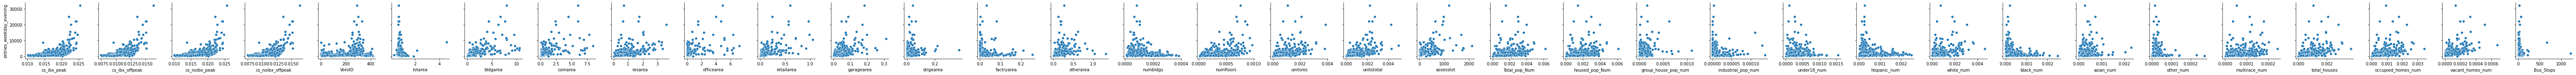

In [261]:
sns.pairplot(data_base_norm, x_vars=['cs_ibx_peak', 'cs_ibx_offpeak',
       'cs_noibx_peak', 'cs_noibx_offpeak', 'VoroID', 'lotarea', 'bldgarea',
       'comarea', 'resarea', 'officearea', 'retailarea', 'garagearea',
       'strgearea', 'factryarea', 'otherarea', 'numbldgs', 'numfloors',
       'unitsres', 'unitstotal', 'assesstot', 'Total_pop_Num',
       'housed_pop_Num', 'group_house_pop_num', 'industrial_pop_num',
       'under18_num', 'hispanic_num', 'white_num', 'black_num', 'asian_num',
       'other_num', 'multirace_num', 'total_houses', 'occupied_homes_num',
       'vacant_homes_num', 'Bus_Stops'], y_vars = 'entries_weekday_evening')

In [206]:
data_base_norm.columns

Index(['complex_id', 'Stop Name', 'Complex_id', 'exits_weekday_evening',
       'entries_weekday_evening', 'exits_weekday_morning',
       'entries_weekday_morning', 'exits_weekday_overnight',
       'entries_weekday_overnight', 'exits_weekend_evening',
       'entries_weekend_evening', 'exits_weekend_morning',
       'entries_weekend_morning', 'exits_weekend_overnight',
       'entries_weekend_overnight', 'cs_ibx_peak', 'cs_ibx_offpeak',
       'cs_noibx_peak', 'cs_noibx_offpeak', 'VoroID', 'lotarea', 'bldgarea',
       'comarea', 'resarea', 'officearea', 'retailarea', 'garagearea',
       'strgearea', 'factryarea', 'otherarea', 'numbldgs', 'numfloors',
       'unitsres', 'unitstotal', 'assesstot', 'Total_pop_Num',
       'housed_pop_Num', 'group_house_pop_num', 'industrial_pop_num',
       'under18_num', 'hispanic_num', 'white_num', 'black_num', 'asian_num',
       'other_num', 'multirace_num', 'total_houses', 'occupied_homes_num',
       'vacant_homes_num', 'Bus_Stops', 'geometry', 

In [245]:
y = np.array(data_base_norm['entries_weekday_morning'])
y = np.reshape(y, (y.shape[0], 1))

q = np.array(data_base_norm['cs_noibx_peak'])
q = np.reshape(q, (q.shape[0], 1))

In [246]:
regressors_norm = data_base_norm.loc[:, ['lotarea', 'bldgarea',
       'comarea', 'resarea', 'officearea', 'retailarea', 'garagearea',
       'strgearea', 'factryarea', 'otherarea', 'numbldgs', 'numfloors',
       'unitsres', 'unitstotal', 'assesstot', 'Total_pop_Num',
       'housed_pop_Num', 'group_house_pop_num', 'industrial_pop_num',
       'under18_num', 'hispanic_num', 'white_num', 'black_num', 'asian_num',
       'other_num', 'multirace_num', 'total_houses', 'occupied_homes_num',
       'vacant_homes_num', 'Bus_Stops']]

,lotarea,bldgarea,comarea,resarea,officearea,retailarea,garagearea,strgearea,factryarea,otherarea,numbldgs,numfloors,unitsres,unitstotal,assesstot,Total_pop_Num,housed_pop_Num,group_house_pop_num,industrial_pop_num,under18_num,hispanic_num,white_num,black_num,asian_num,other_num,multirace_num,total_houses,occupied_homes_num,vacant_homes_num,Bus_Stops
0,0.809811,0.420777,0.117653,0.281819,0.016295,0.019612,0.011350,0.020995,0.024105,0.025193,0.000154,0.000243,0.000338,0.000371,26.869878,0.000781,0.000776,0.000005,0.000000,0.000116,0.000158,0.000487,0.000018,0.000080,0.000010,0.000028,0.000360,0.000338,0.000021,67.0
1,0.641343,10.092060,7.084719,0.699250,5.567793,0.922433,0.142076,0.128086,0.000000,0.324331,0.000052,0.000701,0.000886,0.001521,1796.919035,0.001331,0.001108,0.000223,0.000033,0.000097,0.000224,0.000433,0.000222,0.000399,0.000018,0.000034,0.000945,0.000727,0.000218,2.0
2,0.577556,1.290209,0.374733,0.852644,0.066899,0.060704,0.016903,0.002724,0.024116,0.203360,0.000194,0.000593,0.000938,0.001028,62.122592,0.002807,0.002783,0.000024,0.000002,0.000957,0.000686,0.001901,0.000040,0.000062,0.000055,0.000064,0.000937,0.000865,0.000072,7.0
3,0.718309,1.364211,0.426201,0.909554,0.080981,0.069674,0.021407,0.013649,0.031503,0.208622,0.000117,0.000355,0.000927,0.001004,79.782530,0.002547,0.002531,0.000016,0.000007,0.000826,0.000530,0.001714,0.000107,0.000078,0.000051,0.000067,0.000944,0.000871,0.000073,58.0
4,0.600166,2.555109,1.122051,1.276269,0.424017,0.394570,0.036033,0.034299,0.004312,0.228819,0.000152,0.000731,0.001732,0.002170,355.155533,0.003255,0.003020,0.000235,0.000000,0.000297,0.000466,0.001213,0.000147,0.001292,0.000035,0.000103,0.001719,0.001546,0.000173,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
419,0.662270,1.089839,0.175019,0.825897,0.014863,0.045577,0.004795,0.005180,0.002801,0.101731,0.000252,0.000636,0.000947,0.000985,48.049298,0.002280,0.002211,0.000070,0.000000,0.000350,0.000669,0.000468,0.000895,0.000109,0.000029,0.000110,0.000972,0.000891,0.000081,27.0
420,0.669924,1.093883,0.220558,0.781296,0.049966,0.063710,0.003061,0.009753,0.008532,0.085535,0.000231,0.000583,0.000930,0.000967,50.434389,0.002096,0.002035,0.000061,0.000000,0.000323,0.000521,0.000457,0.000885,0.000108,0.000029,0.000096,0.000923,0.000841,0.000082,36.0
421,0.676527,1.294434,0.235900,0.973783,0.073740,0.070161,0.012139,0.008275,0.011305,0.060132,0.000192,0.000501,0.001215,0.001269,58.793593,0.002375,0.002315,0.000060,0.000002,0.000385,0.000806,0.000528,0.000770,0.000142,0.000028,0.000101,0.001057,0.000965,0.000092,30.0
422,0.731091,1.305348,0.383003,0.906494,0.187046,0.081914,0.004624,0.006420,0.032573,0.069312,0.000086,0.000233,0.001006,0.001062,64.289904,0.002382,0.002329,0.000053,0.000010,0.000518,0.001031,0.000358,0.000724,0.000185,0.000024,0.000061,0.000925,0.000890,0.000035,26.0


In [249]:
X_sel = ['lotarea', 'bldgarea',
       'comarea', 'resarea', 'officearea', 'retailarea', 'garagearea',
       'strgearea', 'factryarea', 'otherarea', 'numbldgs', 'numfloors',
       'unitsres', 'unitstotal', 'assesstot', 'Total_pop_Num',
       'housed_pop_Num', 'group_house_pop_num', 'industrial_pop_num',
       'under18_num', 'hispanic_num', 'white_num', 'black_num', 'asian_num',
       'other_num', 'multirace_num', 'total_houses', 'occupied_homes_num',
       'vacant_homes_num', 'Bus_Stops']

X = regressors_norm.loc[: , X_sel]

X = np.nan_to_num(X)

X = pd.DataFrame(X, columns = X_sel); X

,lotarea,bldgarea,comarea,resarea,officearea,retailarea,garagearea,strgearea,factryarea,otherarea,numbldgs,numfloors,unitsres,unitstotal,assesstot,Total_pop_Num,housed_pop_Num,group_house_pop_num,industrial_pop_num,under18_num,hispanic_num,white_num,black_num,asian_num,other_num,multirace_num,total_houses,occupied_homes_num,vacant_homes_num,Bus_Stops
0,0.809811,0.420777,0.117653,0.281819,0.016295,0.019612,0.011350,0.020995,0.024105,0.025193,0.000154,0.000243,0.000338,0.000371,26.869878,0.000781,0.000776,0.000005,0.000000,0.000116,0.000158,0.000487,0.000018,0.000080,0.000010,0.000028,0.000360,0.000338,0.000021,67.0
1,0.641343,10.092060,7.084719,0.699250,5.567793,0.922433,0.142076,0.128086,0.000000,0.324331,0.000052,0.000701,0.000886,0.001521,1796.919035,0.001331,0.001108,0.000223,0.000033,0.000097,0.000224,0.000433,0.000222,0.000399,0.000018,0.000034,0.000945,0.000727,0.000218,2.0
2,0.577556,1.290209,0.374733,0.852644,0.066899,0.060704,0.016903,0.002724,0.024116,0.203360,0.000194,0.000593,0.000938,0.001028,62.122592,0.002807,0.002783,0.000024,0.000002,0.000957,0.000686,0.001901,0.000040,0.000062,0.000055,0.000064,0.000937,0.000865,0.000072,7.0
3,0.718309,1.364211,0.426201,0.909554,0.080981,0.069674,0.021407,0.013649,0.031503,0.208622,0.000117,0.000355,0.000927,0.001004,79.782530,0.002547,0.002531,0.000016,0.000007,0.000826,0.000530,0.001714,0.000107,0.000078,0.000051,0.000067,0.000944,0.000871,0.000073,58.0
4,0.600166,2.555109,1.122051,1.276269,0.424017,0.394570,0.036033,0.034299,0.004312,0.228819,0.000152,0.000731,0.001732,0.002170,355.155533,0.003255,0.003020,0.000235,0.000000,0.000297,0.000466,0.001213,0.000147,0.001292,0.000035,0.000103,0.001719,0.001546,0.000173,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
419,0.662270,1.089839,0.175019,0.825897,0.014863,0.045577,0.004795,0.005180,0.002801,0.101731,0.000252,0.000636,0.000947,0.000985,48.049298,0.002280,0.002211,0.000070,0.000000,0.000350,0.000669,0.000468,0.000895,0.000109,0.000029,0.000110,0.000972,0.000891,0.000081,27.0
420,0.669924,1.093883,0.220558,0.781296,0.049966,0.063710,0.003061,0.009753,0.008532,0.085535,0.000231,0.000583,0.000930,0.000967,50.434389,0.002096,0.002035,0.000061,0.000000,0.000323,0.000521,0.000457,0.000885,0.000108,0.000029,0.000096,0.000923,0.000841,0.000082,36.0
421,0.676527,1.294434,0.235900,0.973783,0.073740,0.070161,0.012139,0.008275,0.011305,0.060132,0.000192,0.000501,0.001215,0.001269,58.793593,0.002375,0.002315,0.000060,0.000002,0.000385,0.000806,0.000528,0.000770,0.000142,0.000028,0.000101,0.001057,0.000965,0.000092,30.0
422,0.731091,1.305348,0.383003,0.906494,0.187046,0.081914,0.004624,0.006420,0.032573,0.069312,0.000086,0.000233,0.001006,0.001062,64.289904,0.002382,0.002329,0.000053,0.000010,0.000518,0.001031,0.000358,0.000724,0.000185,0.000024,0.000061,0.000925,0.000890,0.000035,26.0


Text(0.5, 1.0, 'Scree Plot')

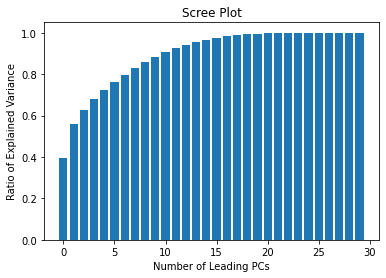

In [305]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

scaled_X = StandardScaler().fit_transform(X)

pca = PCA()

pca_X = pca.fit_transform(scaled_X)

#Plot explained variance per number of leading PC's 
evr = pca.explained_variance_ratio_
plt.bar(np.arange(len(evr)),evr.cumsum())
plt.xlabel('Number of Leading PCs')
plt.ylabel('Ratio of Explained Variance')
plt.title('Scree Plot')

In [231]:
pca_X.shape

(424, 10)

In [250]:
X_arr = []

for col in X.columns:

  X_arr.append(X[col].to_numpy())

X_arr = np.array(X_arr).T
X_arr.shape

(424, 30)

In [253]:
reg = GM_Lag(y, X_arr, q = q, w = W_base_peak, w_lags = 1, name_y = 'entries_weekday_morning', spat_diag=True)

/usr/local/lib/python3.7/dist-packages/spreg/diagnostics.py:331: RuntimeWarning: invalid value encountered in sqrt
  se_result = np.sqrt(variance)
/usr/local/lib/python3.7/dist-packages/spreg/diagnostics.py:147: RuntimeWarning: invalid value encountered in sqrt
  tStat = betas[list(range(0, len(vm)))].reshape(len(vm),) / np.sqrt(variance)


In [254]:
print(reg.summary)

REGRESSION
----------
SUMMARY OF OUTPUT: SPATIAL TWO STAGE LEAST SQUARES
--------------------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  :entries_weekday_morning                Number of Observations:         424
Mean dependent var  :   2906.6205                Number of Variables   :          32
S.D. dependent var  :   3185.3574                Degrees of Freedom    :         392
Pseudo R-squared    :      0.0163
Spatial Pseudo R-squared: omitted due to rho outside the boundary (-1, 1).
------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Probability
------------------------------------------------------------------------------------
            CONSTANT    -5475.3730659    16741.6476203      -0.3270510       0.7436293
               var_1    26451.5931877    1761.1251930      15.0197120       0.0000000
     

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics()
#from sklearn.model_selection import GridSearchCV

#### Log

In [21]:
pd.set_option('max_columns', None)

In [42]:
data_base_log = data_base_log.replace([np.inf, -np.inf], 0); data_base_log

,complex_id,Stop Name,Complex_id,exits_weekday_evening,entries_weekday_evening,exits_weekday_morning,entries_weekday_morning,exits_weekday_overnight,entries_weekday_overnight,exits_weekend_evening,entries_weekend_evening,exits_weekend_morning,entries_weekend_morning,exits_weekend_overnight,entries_weekend_overnight,cs_ibx_peak,cs_ibx_offpeak,cs_noibx_peak,cs_noibx_offpeak,VoroID,lotarea,bldgarea,comarea,resarea,officearea,retailarea,garagearea,strgearea,factryarea,otherarea,numbldgs,numfloors,unitsres,unitstotal,assesstot,Total_pop_Num,housed_pop_Num,group_house_pop_num,industrial_pop_num,under18_num,hispanic_num,white_num,black_num,asian_num,other_num,multirace_num,total_houses,occupied_homes_num,vacant_homes_num,Bus_Stops,geometry,Complex ID,boro,lat,long
0,1,ASTORIA-DITMARS BLVD,R01,8.652707,7.403792,8.148287,8.528484,6.132693,5.475522,8.017204,7.106760,7.674095,7.661939,6.426691,4.908049,0.016242,0.010671,0.016281,0.010718,70.0,17.630596,16.975899,15.701532,16.575058,13.724625,13.909945,13.363050,13.978097,14.116205,14.160365,9.062799,9.519403,9.850441,9.943320,21.132556,10.686734,10.680074,5.671646,0.000000,8.783198,9.086447,10.213574,6.943512,8.410315,6.302721,7.371530,9.911190,9.850095,7.085475,4.204693,MULTIPOLYGON (((1009459.8773626394 218152.2372...,1,Q,40.775036,-73.912034
1,10,49 ST,R15,8.461638,8.514505,8.931188,8.060501,6.083417,5.744684,8.486966,8.321832,8.538979,7.855738,6.474373,6.325367,0.022245,0.013315,0.022382,0.013371,307.0,13.669265,16.425204,16.071395,13.755709,15.830454,14.032714,12.162063,12.058400,0.000000,12.987466,4.250825,6.850687,7.084588,7.625215,21.607284,7.491832,7.308456,5.705329,3.784344,4.876557,5.710162,6.369599,5.702556,6.287261,3.188194,3.829414,7.149632,6.887089,5.683890,0.693147,POLYGON ((989185.1866888272 216357.86476792034...,10,M,40.759901,-73.984139
2,100,HEWES ST,M14,6.842657,6.363287,6.721727,6.334966,5.211806,4.220977,6.578296,5.851664,6.042039,5.622211,5.622437,4.327438,0.020128,0.012387,0.020046,0.012377,179.0,14.534087,15.337841,14.101496,14.923624,12.378465,12.281295,11.002797,9.177329,11.358155,13.490262,6.537753,7.653371,8.110755,8.202652,19.212147,9.207392,9.198816,4.444276,1.685130,8.131600,7.798253,8.817585,4.953395,5.392477,5.272092,5.420767,8.110404,8.030336,5.545750,1.945910,"POLYGON ((996888.2585780247 198332.7126279529,...",100,Bk,40.706870,-73.953431
3,101,MARCY AV,M16,8.269411,7.801606,8.124284,7.646867,6.278850,5.635057,7.918560,7.270791,7.534562,6.898084,6.626801,5.833531,0.020578,0.012626,0.020522,0.012624,180.0,16.434464,17.075895,15.912474,16.670518,14.251774,14.101396,12.921272,12.471208,13.307646,15.198090,7.709226,8.821562,9.781926,9.861856,21.144624,10.792410,10.786134,5.718285,4.946630,9.666835,9.222319,10.396247,7.622212,7.311999,6.875067,7.157745,9.800038,9.719475,7.241308,4.060443,POLYGON ((995891.3762889279 194519.11313010252...,101,Bk,40.708359,-73.957757
4,103,BOWERY,M19,6.841776,6.487874,7.250511,6.326105,4.791442,3.824284,7.013747,6.454904,7.322717,6.080791,5.368601,4.912655,0.020696,0.011852,0.020766,0.011917,279.0,13.767938,15.216583,14.393646,14.522429,13.420507,13.348530,10.955179,10.905860,8.832096,12.803664,5.488691,7.056912,7.920266,8.145508,20.151044,8.550787,8.475888,5.921961,0.000000,6.155664,6.606777,7.563697,5.451459,7.626830,4.006081,5.095052,7.912346,7.806271,5.616165,1.098612,POLYGON ((986852.7345749646 201652.06074943082...,103,M,40.720280,-73.993915
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
419,95,GATES AV,J30,7.134074,6.931692,6.462132,7.479215,5.629508,4.824707,6.613049,6.547592,5.826553,6.671083,5.768712,4.747104,0.017714,0.010729,0.017565,0.010743,151.0,15.443623,15.941735,14.112842,15.664420,11.646843,12.767356,10.515421,10.592798,9.977850,13.570278,7.569214,8.495740,8.893599,8.932900,19.727933,9.772230,9.741209,6.283680,0.000000,7.896938,8.5453

In [53]:
map_dict = {}

for i in data_base_log.index:
  map_dict[i] = data_base_log.iloc[i, 0]

In [56]:
map_dict

{0: '1',
 1: '10',
 2: '100',
 3: '101',
 4: '103',
 5: '107',
 6: '108',
 7: '109',
 8: '110',
 9: '111',
 10: '113',
 11: '114',
 12: '118',
 13: '119',
 14: '120',
 15: '122',
 16: '123',
 17: '124',
 18: '125',
 19: '126',
 20: '127',
 21: '129',
 22: '13',
 23: '130',
 24: '131',
 25: '133',
 26: '134',
 27: '135',
 28: '136',
 29: '137',
 30: '138',
 31: '14',
 32: '141',
 33: '143',
 34: '144',
 35: '145',
 36: '146',
 37: '147',
 38: '149',
 39: '150',
 40: '151',
 41: '152',
 42: '153',
 43: '154',
 44: '155',
 45: '156',
 46: '157',
 47: '158',
 48: '159',
 49: '16',
 50: '160',
 51: '162',
 52: '164',
 53: '165',
 54: '167',
 55: '168',
 56: '169',
 57: '17',
 58: '173',
 59: '175',
 60: '176',
 61: '177',
 62: '179',
 63: '180',
 64: '181',
 65: '182',
 66: '183',
 67: '185',
 68: '186',
 69: '187',
 70: '188',
 71: '189',
 72: '190',
 73: '191',
 74: '192',
 75: '193',
 76: '194',
 77: '195',
 78: '196',
 79: '197',
 80: '198',
 81: '199',
 82: '2',
 83: '20',
 84: '200',


In [43]:
regressors_log = data_base_log.loc[:, ['complex_id','cs_noibx_peak','cs_noibx_offpeak','lotarea', 'bldgarea',
       'comarea', 'resarea', 'officearea', 'retailarea', 'garagearea',
       'strgearea', 'factryarea', 'otherarea', 'numbldgs', 'numfloors',
       'unitsres', 'unitstotal', 'assesstot', 'Total_pop_Num',
       'housed_pop_Num', 'group_house_pop_num', 'industrial_pop_num',
       'under18_num', 'hispanic_num', 'white_num', 'black_num', 'asian_num',
       'other_num', 'multirace_num', 'total_houses', 'occupied_homes_num',
       'vacant_homes_num', 'Bus_Stops']]

In [16]:
y_vars = ['exits_weekday_evening','entries_weekday_evening', 'exits_weekday_morning', 'entries_weekday_morning', 'exits_weekday_overnight',
       'entries_weekday_overnight', 'exits_weekend_evening','entries_weekend_evening', 'exits_weekend_morning',
       'entries_weekend_morning', 'exits_weekend_overnight',
       'entries_weekend_overnight']

#_vars_sp = data_base_log.loc[:, y_vars + ['long'] + ['lat']]

In [91]:
y = np.array(data_base_log['entries_weekday_evening'])
y = np.reshape(y, (y.shape[0], 1))

In [45]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

cols_housing = ['unitsres','unitstotal','total_houses', 'occupied_homes_num',
       'vacant_homes_num','resarea']

cols_dems = ['Total_pop_Num',
       'housed_pop_Num', 'group_house_pop_num', 'industrial_pop_num',
       'under18_num', 'hispanic_num', 'white_num', 'black_num', 'asian_num',
       'other_num', 'multirace_num']

#composite score for housing 
X_log_scale_hs = StandardScaler().fit_transform(regressors_log[cols_housing])
pca_hs = PCA(n_components=1)
housing_composite = pca_hs.fit_transform(X_log_scale_hs)
regressors_log['housing_ind'] = housing_composite

#and demographics 
X_log_scale_dem = StandardScaler().fit_transform(regressors_log[cols_dems])
pca_dem = PCA(n_components=1)
demo_composite = pca_dem.fit_transform(X_log_scale_dem)
regressors_log['dem_ind'] = demo_composite

In [48]:
X_sel = ['cs_noibx_peak','lotarea', 'bldgarea','comarea', 'officearea', 'retailarea',
         'Bus_Stops', 'assesstot', 'housing_ind', 'dem_ind']

X_log_ind = regressors_log.loc[:, X_sel]

#X_log_ind = np.nan_to_num(X_log_ind)

X_log_ind

,cs_noibx_peak,lotarea,bldgarea,comarea,officearea,retailarea,Bus_Stops,assesstot,housing_ind,dem_ind
0,0.016281,17.630596,16.975899,15.701532,13.724625,13.909945,4.204693,21.132556,3.651528,2.861110
1,0.022382,13.669265,16.425204,16.071395,15.830454,14.032714,0.693147,21.607284,-4.513407,-5.654518
2,0.020046,14.534087,15.337841,14.101496,12.378465,12.281295,1.945910,19.212147,-1.904407,-1.260745
3,0.020522,16.434464,17.075895,15.912474,14.251774,14.101396,4.060443,21.144624,3.562187,3.780477
4,0.020766,13.767938,15.216583,14.393646,13.420507,13.348530,1.098612,20.151044,-2.456482,-3.092681
...,...,...,...,...,...,...,...,...,...,...
419,0.017565,15.443623,15.941735,14.112842,11.646843,12.767356,3.295837,19.727933,0.648170,0.883749
420,0.017442,15.460979,15.951304,14.349974,12.865151,13.108158,3.583519,19.782243,0.563849,0.643554
421,0.019223,15.638366,16.287223,14.584803,13.421939,13.372181,3.401197,20.103182,1.729889,1.699137
422,0.019298,15.324024,15.903711,14.677529,13.960838,13.135160,3.258097,19.800644,-0.349642,0.546521


In [ ]:
for col in y_vars:

  if 'weekend' in col or 'overnight' in col:

    y = np.array(data_base_log[col])
    y = np.reshape(y, (y.shape[0], 1))

    X_sel = ['cs_noibx_offpeak','lotarea', 'bldgarea','comarea', 'officearea', 'retailarea',
         'Bus_Stops', 'assesstot', 'housing_ind', 'dem_ind']

    X_log_ind = regressors_log.loc[:, X_sel]

    X_log_ind = np.nan_to_num(X_log_ind)

    reg_log = GM_Lag(y, X_log_ind, w = W_base_offpeak, w_lags = 1, name_y = col, name_x = X_sel)

    print(col, D.r2(reg_log), reg_log.betas[1])

  else:

    y = np.array(data_base_log[col])
    y = np.reshape(y, (y.shape[0], 1))

    X_sel = ['cs_noibx_peak','lotarea', 'bldgarea','comarea', 'officearea', 'retailarea',
         'Bus_Stops', 'Total_pop_Num', 'assesstot', 'housing_ind', 'dem_ind']

    X_log_ind = regressors_log.loc[:, X_sel]

    X_log_ind = np.nan_to_num(X_log_ind)

    reg_log = GM_Lag(y, X_log_ind, w = W_base_peak, w_lags = 1, name_y = col, name_x = X_sel)

    print(col, D.r2(reg_log), reg_log.betas[1])

#### Spatial Cross-Validation Test

In [95]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_log_ind, y, test_size = 0.2)

In [96]:
x_train_ind = X_train.index
x_test_ind = X_test.index

test = W_base_peakdf

train_W = test.filter(x_train_ind, axis = 'index')
train_W = train_W.filter(x_train_ind, axis = 'columns')

test_W = test.filter(x_test_ind, axis = 'index')
test_W = test_W.filter(x_test_ind, axis = 'columns')

In [97]:
train_W

,192,155,172,210,224,42,214,222,211,330,109,332,340,238,179,421,228,87,115,49,244,263,131,163,365,249,414,217,134,51,111,86,292,156,50,40,188,412,256,81,195,298,389,22,137,32,395,399,317,257,226,232,143,418,370,11,171,229,152,52,166,148,280,403,153,273,200,358,225,177,321,29,264,149,96,187,112,385,74,394,275,356,413,294,289,377,99,342,94,335,206,212,323,371,378,347,288,386,420,363,213,319,305,379,253,158,239,388,191,37,234,314,126,274,38,178,241,82,121,123,159,65,161,21,43,309,28,41,235,39,133,130,362,144,181,352,35,401,240,205,176,271,12,322,247,17,266,422,173,341,336,346,128,411,146,33,268,199,368,308,105,415,419,125,89,151,66,63,150,10,54,251,0,259,262,95,409,102,311,396,31,357,56,281,88,327,3,366,215,138,312,306,53,279,44,260,184,118,127,62,295,204,291,84,338,297,5,408,75,343,276,202,344,91,325,331,333,4,407,284,272,196,20,24,320,350,116,67,117,384,369,207,349,364,132,71,290,154,80,354,73,242,9,77,97,302,353,296,339,381,122,221,101,367,360,114,197,265,190,216,301,324,404,157,59,405,47,237,180,269,106,236,283,136,68,90,170,391,286,85,18,162,380,140,76,372,83,27,129,303,416,175,110,233,135,69,219,164,304,277,245,160,120,93,145,231,316,334,23,406,8,26,19,141,168,299,243,34,315,107,79,48,282,318,230,250,15,183,374,337,252,390,383,72,194,278,103,46,267
192,0.000000,66.314920,41.259933,45.597435,65.781085,38.772371,51.389270,63.506858,65.724759,40.686843,29.788910,35.780398,61.687027,80.362376,30.382169,51.806204,56.712789,99.619086,47.410352,34.271012,72.918340,61.736392,75.429238,63.728804,14.800350,64.808168,30.493602,57.429752,76.427214,29.084053,40.120550,98.070058,60.635434,54.365818,29.702436,45.293017,17.211698,72.425702,71.162568,90.473336,57.100011,54.264814,71.005100,30.102355,60.784164,66.770804,63.743710,72.436986,56.976907,69.700429,53.409465,69.214135,57.763642,66.159175,50.365112,53.410913,42.949776,58.307685,31.291987,29.158892,59.860901,47.536955,48.494281,32.159113,28.826029,48.200757,20.985205,35.295588,51.986544,36.604607,52.300021,66.471320,74.665806,45.930758,56.789104,18.735286,37.927149,56.063007,72.532110,78.716654,46.841571,44.179186,73.208904,56.123726,66.362822,54.586867,52.477038,63.520266,63.805588,30.453250,35.438644,47.329077,49.632823,47.503625,40.109741,73.732624,68.200424,29.754124,63.122268,65.070834,48.963298,57.040066,40.060935,36.440101,75.064382,54.361383,78.395077,69.411721,13.050729,48.141724,85.442269,71.167440,67.015609,44.143625,46.156272,34.924053,75.441610,46.844922,59.851640,63.392784,57.505154,58.994769,61.315252,54.866616,37.424180,34.168420,64.396458,40.607078,84.346312,44.793355,78.377208,73.316322,31.942895,55.712564,26.848036,41.382422,51.070495,76.247286,76.939689,64.323523,58.347449,51.123778,35.283037,50.966446,67.545522,46.931750,55.517576,50.434032,39.841558,42.594053,39.292086,71.095424,69.961910,73.655083,51.260784,54.500737,56.417581,19.587678,14.715823,55.427043,47.321417,70.130326,63.657907,65.620307,97.396245,38.990557,60.627678,55.287357,43.718057,55.000175,37.278535,61.997270,48.555853,67.000592,63.082526,58.601389,75.970469,47.983653,80.281921,65.344595,31.299821,49.146143,37.134199,51.397211,95.841989,43.056372,46.374982,35.577407,53.107662,44.729224,77.318130,38.006783,30.741881,51.842359,36.250082,65.509824,21.549231,54.135941,68.551474,53.068192,54.675766,25.182820,62.924440,95.307356,34.957484,50.661745,51.689845,79.465024,73.684602,65.729941,47.761233,22.933655,68.045521,101.186298,46.002154,41.427047,34.904677,50.979062,78.900680,72.567532,49.875519,15.091238,51.394821,58.131418,53.585172,77.548785,49.042947,63.653876,50.701081,46.708295,70.610485,39.603301,76.472363,32.237334,80.280658,68.569675,64.555812,67.626217,77.872928,19.926702,71.152529,74.466117,57.822290,76.066068,55.293902,45.261877,63.877075,52.859071,60.640862,52.929719,61.815436,61.678193,49.524468,36.501533,32.068239,43.500857,15.984042,52.676563,14.339129,55.014886,46.792841,47.241092,79.947815,64.620772,46.553540,82.258431,32.392110,81.400976,28.182242,55.066194,45.029750,82.632070,74.0

In [99]:
wts_train = train_W.to_dict(orient = 'list')

wts_test = test_W.to_dict(orient = 'list')

neigh_train = {}

neigh_test = {}

for x in train_W.index.to_list():

  neigh_train[x] = train_W.columns.to_list()

for x in test_W.index.to_list():

  neigh_test[x] = test_W.columns.to_list()

w_train = weights.W(neighbors=neigh_train, weights=wts_train)

w_train.transform = 'r'

w_test = weights.W(neighbors=neigh_test, weights=wts_test)

w_test.transform = 'r'

In [107]:
X_train = np.nan_to_num(X_train, neginf=0, posinf=0)
reg_train = GM_Lag(y_train, X_train, w = w_train, name_x = X_sel) 

In [113]:
print(reg_train.summary)

REGRESSION
----------
SUMMARY OF OUTPUT: SPATIAL TWO STAGE LEAST SQUARES
--------------------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  :     dep_var                Number of Observations:         339
Mean dependent var  :      7.1151                Number of Variables   :          12
S.D. dependent var  :      1.1599                Degrees of Freedom    :         327
Pseudo R-squared    :      0.6207
Spatial Pseudo R-squared: omitted due to rho outside the boundary (-1, 1).
------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Probability
------------------------------------------------------------------------------------
            CONSTANT      16.7748465      21.5898261       0.7769792       0.4371710
       cs_noibx_peak     119.9143739      25.4149999       4.7182520       0.0000024
             lotare

#### Absolute

In [306]:
data_base_abs = data_base_abs.replace([np.inf, -np.inf], 0);

In [310]:
y = np.array(np.log(data_base_abs['entries_weekday_morning']))
y = np.reshape(y, (y.shape[0], 1))

In [311]:
regressors_abs = data_base_abs.loc[:, ['complex_id','cs_noibx_peak','lotarea', 'bldgarea',
       'comarea', 'resarea', 'officearea', 'retailarea', 'garagearea',
       'strgearea', 'factryarea', 'otherarea', 'numbldgs', 'numfloors',
       'unitsres', 'unitstotal', 'assesstot', 'Total_pop_Num',
       'housed_pop_Num', 'group_house_pop_num', 'industrial_pop_num',
       'under18_num', 'hispanic_num', 'white_num', 'black_num', 'asian_num',
       'other_num', 'multirace_num', 'total_houses', 'occupied_homes_num',
       'vacant_homes_num', 'Bus_Stops']]

In [312]:
X_sel = ['cs_noibx_peak','lotarea', 'bldgarea','comarea', 'officearea', 'retailarea', 'Bus_Stops', 'Total_pop_Num', 'assesstot']

X_abs = regressors_abs.loc[:, X_sel]

X_abs = np.nan_to_num(X_abs)


In [313]:
X_abs.shape

(424, 9)

In [314]:
reg_abs = GM_Lag(y, X_abs, w = W_base_peak, w_lags = 1, name_y = 'entries_weekday_morning', name_x = X_sel)
print(reg_abs.summary)

REGRESSION
----------
SUMMARY OF OUTPUT: SPATIAL TWO STAGE LEAST SQUARES
--------------------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  :entries_weekday_morning                Number of Observations:         424
Mean dependent var  :      7.6195                Number of Variables   :          11
S.D. dependent var  :      0.8987                Degrees of Freedom    :         413
Pseudo R-squared    :      0.3711
Spatial Pseudo R-squared: omitted due to rho outside the boundary (-1, 1).
------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Probability
------------------------------------------------------------------------------------
            CONSTANT      41.4725581       5.8708433       7.0641568       0.0000000
       cs_noibx_peak      56.9084890      15.4647436       3.6798857       0.0002333
        